## Flow diagram of the code
<img width='800px' src="https://raw.githubusercontent.com/GordonCai/Project-Deep-Reinforcement-Learning-Policy-Gradient/master/Notes/Flow%20diagram.jpg?token=AQBiH8u2IVhnT6KahLiMP9KQwwkp01eYks5ZATkqwA%3D%3D">

#### Reference: 
https://gist.github.com/greydanus/5036f784eec2036252e1990da21eda18

https://medium.com/@dhruvp/how-to-write-a-neural-network-to-play-pong-from-scratch-956b57d4f6e0

https://github.com/yukezhu/tensorflow-reinforce/blob/master/rl/pg_reinforce.py

In [5]:
import numpy as np
import random
import gym
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
from time import time

# Initialize OpenAI for Pong
start = time()
env = gym.make("Pong-v0")

# Hyper parameters for policy gradient model
global num_actions, discount, batch_size
num_actions = 3 # env.action_space.n # 6
discount = 0.99
save_every = 50
train_every = 1
batch_size = 1000
max_episode = 10001 # When to terminate traininig
initial_exp = 0.3 # Initial exploration probability
final_exp = 0.01 # Final exploration probability

# Hyper parameters for Network
global L2_reg
L2_reg = 0.00001
learning_rate=0.0005; epsilon=1e-6
FC_param = {'FC_1':400}

# Initialize parameter for policy gradient model 
observation = env.reset()
image_old  = None
images, fake_labels, rewards_std, action_hist, reward_hist, reward_runn = [], [], [], [], [], []
reward_episode = 0

# Build network
def Network(image_, FC_param, CNN_param=None):
    
    if CNN_param!=None:
        conv_tmp = tf.layers.conv2d(inputs=image_,
                                    filters=CNN_param['conv_1'][0],
                                    kernel_size=[CNN_param['conv_1'][1], CNN_param['conv_1'][1]],
                                    strides = CNN_param['conv_1'][2],
                                    padding="same",
                                    activation=tf.nn.relu,
#                                     use_bias=False,
                                    name='conv_1')

        for key,value in CNN_param.items():
            if key != 'conv_1':
                conv_tmp = tf.layers.conv2d(inputs=conv_tmp,
                                            filters=value[0],
                                            kernel_size=[value[1], value[1]],
                                            strides = value[2],
                                            padding="same",
                                            activation=tf.nn.relu,
#                                             use_bias=False,
                                            name=key)
    
    if CNN_param==None:
        FC_tmp = tf.contrib.layers.flatten(image_, scope='Flatten')
    else:
        FC_tmp = tf.contrib.layers.flatten(conv_tmp, scope='Flatten')
    
    for key,value in FC_param.items():
        FC_tmp = tf.layers.dense(inputs=FC_tmp, 
                                 units=value,
                                 kernel_regularizer=tf.contrib.layers.l2_regularizer(L2_reg),
                                 kernel_initializer= tf.truncated_normal_initializer(mean=0,
                                                                                     stddev=1./np.sqrt(5000), 
                                                                                     dtype=tf.float32),
                                 activation=tf.nn.relu,
                                 use_bias=False,
                                 name=key)
    
    logits = tf.layers.dense(inputs=FC_tmp, 
                             units=num_actions, 
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(L2_reg),
                             kernel_initializer= tf.truncated_normal_initializer(mean=0,
                                                                                 stddev=1./np.sqrt(500), 
                                                                                 dtype=tf.float32),
                             use_bias=False,
                             name='Logits')
    
    action_probs = tf.nn.softmax(logits, name='SoftMax')
    
    return action_probs

# Get discounted reward and normalize it
def discount_norm(rew):
    rew_func = lambda a, v: a*discount + v # Reward function
    
    rew_reverse = tf.scan(rew_func, tf.reverse(rew,[True, False]))
    discounted_rew = tf.reverse(rew_reverse,[True, False])
    
    mean, variance= tf.nn.moments(discounted_rew, [0])
    discounted_rew -= mean
    discounted_rew /= tf.sqrt(variance + 1e-6)
    
    return discounted_rew

# Process image by cropping and binarizing
def process_obs(obs):
    obs = obs[35:195]
    obs = obs[::2,::2,0]
    obs[obs == 144] = 0
    obs[obs == 109] = 0
    obs[obs != 0] = 1 
    return obs.astype(np.float)

# Break down into batch jobs to reduce GPU/CPU load
def gen_batch_index(num_of_steps):
    batch_index = []
    start = 0
    for index in np.array(range(0,len(images),batch_size)):
        end=index
        if end > 0:
            batch_index.append([start,end])
        start=index
    end = len(images)
    batch_index.append([start,end])
    return batch_index

# Build model
with tf.Graph().as_default() as g:
    with tf.device("/cpu:0"):
        image_ = tf.placeholder(dtype=tf.float32, shape=[None, 80,80,1],name="image")
        fake_label_ = tf.placeholder(dtype=tf.float32, shape=[None, num_actions],name="fake_label")
        reward_ = tf.placeholder(dtype=tf.float32, shape=[None,1], name="reward")

        discounted_epr = discount_norm(reward_) # Get policy gradient

        tf_aprob = Network(image_,FC_param,CNN_param)
        loss = tf.nn.l2_loss(fake_label_-tf_aprob) # Define loss
        optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=0.99)
#         optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1e-3)
        grads = optimizer.compute_gradients(loss, var_list=tf.trainable_variables(), grad_loss=discounted_epr)
        train_op = optimizer.apply_gradients(grads)

# Main program
with g.as_default(), tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    saver = tf.train.Saver(tf.global_variables())
    
    # Load from last session or start over
    try:
        episode_number = pickle.load(open('PG-Pong-ckpt-2/last-episode.p','rb'))
        saver.restore(sess, 'PG-Pong-ckpt-2\\Pong_PG.ckpt-'+str(episode_number))
        reward_hist = pickle.load(open('PG-Pong-ckpt-2/all_reward.p','rb'))
        print('Continue from last saved episode')
    except:
        print('Training from beginning')
        episode_number = 0
        
    # Starting playing
    while episode_number<=max_episode:
    #     if True: env.render()
        image_proc = process_obs(observation)
        image_diff = image_proc - image_old if image_old is not None else np.zeros((80,80))
        image_old = image_proc
        
        # Epsilon greedy exploration
        ratio = np.max((max_episode - episode_number)/max_episode, 0)
        exploration_prob = (initial_exp - final_exp) * ratio + final_exp
        if random.random() < exploration_prob:
            action = random.randint(0, num_actions-1)
        else:
            # Uniformly pick an action
            feed_step = {image_: np.reshape(image_diff, (1,80,80,1))}
            aprob = sess.run(tf_aprob,feed_step) ; aprob = aprob[0,:]
            action = np.argmax(aprob)
        
        # Generate fake label for back prop
        label = np.zeros_like(aprob) ; label[action] = 1

        # Input action to OpenAI and get feedback
        observation, reward, done, info = env.step(action+1)
        reward_episode += reward

        # Record for training
        images.append(image_diff); fake_labels.append(label); rewards_std.append(reward); action_hist.append(action+1)

        # Training
        if done:
            
            if episode_number % train_every == 0:
                
                # Use stochastic gradient decent if using CNN
                if CNN_param!=None:
                    batch_index = gen_batch_index(len(images))
                    for item in batch_index:
                        feed_episode = {image_: np.array(images[item[0]:item[1]]).reshape(-1, 80, 80, 1), 
                                fake_label_: np.array(fake_labels[item[0]:item[1]]).reshape(-1,num_actions), 
                                reward_: np.array(rewards_std[item[0]:item[1]]).reshape(-1,1)}
                        sess.run(train_op,feed_episode)
                else:
                    feed_episode = {image_: np.array(images).reshape(-1, 80, 80, 1), 
                            fake_label_: np.array(fake_labels).reshape(-1,num_actions), 
                            reward_: np.array(rewards_std).reshape(-1,1)}
                    sess.run(train_op,feed_episode)
                    
                # Clear memory
                images, fake_labels, rewards_std, action_hist = [], [], [], []
            
            # Bookkeeping
            reward_hist.append(reward_episode)
            reward_runn.append(reward_episode)
            episode_number += 1
            observation = env.reset()
            print('\tep {}: reward: {}'.format(episode_number, reward_episode))
            reward_episode = 0
            
            # Save model
            if episode_number % save_every == 0:
                saver.save(sess, 'PG-Pong-ckpt-2/Pong_PG.ckpt', global_step=episode_number)
                print('Model saved, mean reward is',np.mean(reward_runn))
                pickle.dump(episode_number,open('PG-Pong-ckpt-2/last-episode.p','wb'))
                pickle.dump(reward_hist,open('PG-Pong-ckpt-2/all_reward.p','wb'))
#                 plt.hist(np.array(action_hist))
#                 plt.show()
                reward_runn = []


[2017-04-23 08:17:32,556] Making new env: Pong-v0


Continue from last saved episode
	ep 6551: reward: -7.0
	ep 6552: reward: -6.0
	ep 6553: reward: -6.0
	ep 6554: reward: 1.0
	ep 6555: reward: 3.0
	ep 6556: reward: -14.0
	ep 6557: reward: -9.0
	ep 6558: reward: 7.0
	ep 6559: reward: -10.0
	ep 6560: reward: -11.0
	ep 6561: reward: -8.0
	ep 6562: reward: -9.0
	ep 6563: reward: -1.0
	ep 6564: reward: -7.0
	ep 6565: reward: -7.0
	ep 6566: reward: -7.0


KeyboardInterrupt: 

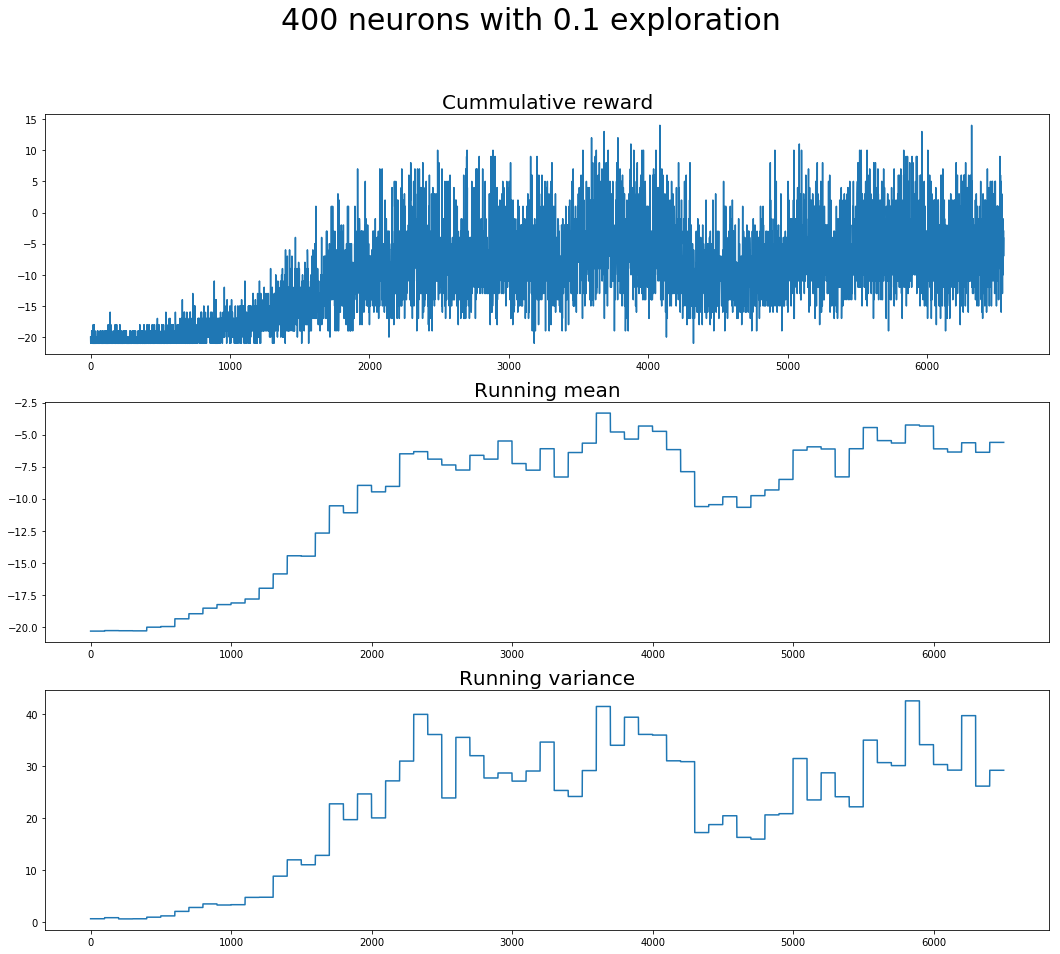

In [4]:
# Plotting
interval = 100
running_mean=[]; running_var=[]
for i in range(np.floor(len(reward_hist)/interval).astype('int32')):
    running_mean.extend([np.mean(reward_hist[i*interval:i*interval+interval+1])]*interval)
    running_var.extend([np.var(reward_hist[i*interval:i*interval+interval+1])]*interval)

fig,axe = plt.subplots(3,1,figsize=(18,15))
plt.suptitle('400 neurons with 0.1 exploration',fontsize=30)
axe[0].plot(np.array(reward_hist))
axe[0].set_title('Cummulative reward',fontsize=20)
axe[1].plot(np.array(running_mean))
axe[1].set_title('Running mean',fontsize=20)
axe[2].plot(np.array(running_var))
axe[2].set_title('Running variance',fontsize=20)
plt.show()
fig.savefig('PG-Pong-ckpt-2/ANN2.jpg')